In [ ]:
import os
import sys

# Standardize working directory to project root
try:
    if os.path.basename(os.getcwd()) in ['modeling', 'scraping', 'data-prep', 'analysis', 'setup', 'misc']:
        os.chdir('../..')
    elif os.path.basename(os.getcwd()) == 'notebooks':
        os.chdir('..')
        
    if os.getcwd() not in sys.path:
        sys.path.append(os.getcwd())
        
    print(f"Working Directory set to: {os.getcwd()}")
except Exception as e:
    print(f"Failed to set working directory: {e}")

In [1]:
# !pip install seaborn

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mynnlib
from mynnlib import *

dataset_dir = "insect-dataset/butterfly"

early_regex = r"^.*-(early)$"
unidentified_regex = r"^.*-(spp|genera|genera-spp)$"
early_or_unidentified_regex = r"^.*-(early|spp|genera|genera-spp)$"

# Dataset stats

In [36]:
classes = { class_dir: len([ img for img in os.listdir(f"{dataset_dir}/data/{class_dir}") ]) for class_dir in os.listdir(f"{dataset_dir}/data") }
early_classes = { class_name: count for class_name, count in classes.items() if re.match(early_regex, class_name) }
unidentified_classes = { class_name: count for class_name, count in classes.items() if re.match(unidentified_regex, class_name) }
print(f"Total Class count : {len(classes):6} ( Unidentified: {len(unidentified_classes):6} / Early-stage: {len(early_classes):6} / Identified-adult: {len(classes) - len(unidentified_classes) - len(early_classes):6} )")
print(f"Total  Data count : {sum(classes.values()):6} ( Unidentified: {sum(unidentified_classes.values()):6} / Early-stage: {sum(early_classes.values()):6} / Identified-adult: {sum(classes.values()) - sum(unidentified_classes.values()) - sum(early_classes.values()):6} )")

Total Class count :   1554 ( Unidentified:     35 / Early-stage:    429 / Identified-adult:   1090 )
Total  Data count :  66362 ( Unidentified:   1864 / Early-stage:  10762 / Identified-adult:  53736 )


In [37]:
img2_class = []
img5_class = []
for class_dir in os.listdir(f"{dataset_dir}/data"):
    if not re.match(early_or_unidentified_regex, class_dir):
        img_cnt = sum([1 for file in os.listdir(f"{dataset_dir}/data/{class_dir}")])
        img2_class += [class_dir] if img_cnt <= 2 else []
        img5_class += [class_dir] if img_cnt <= 5 else []
print(f"{len(img2_class):6} classes with <=2 images")
print(f"{len(img5_class):6} classes with <=5 images")

    64 classes with <=2 images
   168 classes with <=5 images


In [44]:
generas = set()
for class_name in classes:
    generas.add(class_name.split('-')[0])
print(f"Genera count: {len(generas)}")

Genera count: 351


-----------
# Train

### Model A (resnet-152 + only imago data)

In [56]:
training_params = [
    { "idx": 1, "robustness": 0.2, "break_at_val_acc_diff": 0.05},
    { "idx": 2, "robustness": 0.5, "break_at_val_acc_diff": 0.02},
    { "idx": 3, "robustness": 1.0, "break_at_val_acc_diff": 0.01},
    { "idx": 4, "robustness": 2.0, "break_at_val_acc_diff": -0.000001}
]
for param in training_params:
    print(f"Phase {param["idx"]}:")
    if param["idx"] == 1:
        model_data = init_model_for_training(f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                             batch_size=32, arch="resnet152", image_size=224, robustness=param["robustness"],
                                             lr=1e-4, weight_decay=1e-4, silent=True)
    else:
        model_data = prepare_for_retraining(model_data, f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                            batch_size=32, image_size=224, robustness=param["robustness"], silent=True)
    train(model_data, 5, f"{dataset_dir}/checkpoint.butterfly.ta.ep{param["idx"]:02}###.pth", 
          break_at_val_acc_diff=param["break_at_val_acc_diff"])

Phase 1:
Epoch    1 /    5  | Train Loss: 2.2722 Acc: 0.5376  | Val Loss: 1.6662 Acc: 0.6118  | Elapsed time: 0:18:37.814795
Epoch    2 /    5  | Train Loss: 0.5177 Acc: 0.8594  | Val Loss: 1.2701 Acc: 0.6706  | Elapsed time: 0:36:56.316690
Epoch    3 /    5  | Train Loss: 0.2839 Acc: 0.9197  | Val Loss: 1.1690 Acc: 0.6941  | Elapsed time: 0:55:27.259901
Phase 2:
Epoch    1 /    5  | Train Loss: 1.3028 Acc: 0.6716  | Val Loss: 1.0681 Acc: 0.7118  | Elapsed time: 0:19:17.592222
Epoch    2 /    5  | Train Loss: 1.0269 Acc: 0.7386  | Val Loss: 0.9693 Acc: 0.7706  | Elapsed time: 0:38:38.703246
Epoch    3 /    5  | Train Loss: 0.9482 Acc: 0.7597  | Val Loss: 0.9419 Acc: 0.7882  | Elapsed time: 0:57:48.982457
Phase 3:
Epoch    1 /    5  | Train Loss: 0.9277 Acc: 0.7639  | Val Loss: 0.9357 Acc: 0.7706  | Elapsed time: 0:19:15.900564
Epoch    2 /    5  | Train Loss: 0.7238 Acc: 0.8178  | Val Loss: 0.8696 Acc: 0.7941  | Elapsed time: 0:38:17.507498
Epoch    3 /    5  | Train Loss: 0.6603 Acc: 

In [4]:
model_data = torch.load(f"{dataset_dir}/checkpoint.butterfly.ta.ep040001.pth", weights_only=False)

In [5]:
test_top_k(model_data, f"{dataset_dir}/../butterfly/random-test", 3, print_preds=False, print_top1_accuracy=True, print_no_match=False)
test_top_k(model_data, f"{dataset_dir}/../butterfly/random-test", 5, print_preds=False, print_top1_accuracy=False)
test_top_k(model_data, f"{dataset_dir}/../butterfly/random-test", 10, print_preds=False, print_top1_accuracy=False)

Top   1 accuracy: 126/153 -> 82.35%, genus matched: 140/153 -> 91.50%
Top   3 accuracy: 136/153 -> 88.89%, genus matched: 150/153 -> 98.04%
Top   5 accuracy: 141/153 -> 92.16%, genus matched: 152/153 -> 99.35%
Top  10 accuracy: 148/153 -> 96.73%, genus matched: 152/153 -> 99.35%


In [8]:
test_top_k(model_data, f"{dataset_dir}/../butterfly/my-test", 3, print_preds=True, print_top1_accuracy=True, print_no_match=False)

acraea-terpsicore             : acraea-terpsicore(0.935)  coladenia-indrani(0.025)  byblia-ilithyia(0.011)  
athyma-pravara                : neptis-clinia(0.358)  neptis-neptis-spp(0.326)  athyma-kanwa(0.089)  
colias-fieldii                : colias-fieldii(0.990)  colias-erate(0.008)  colias-nilagiriensis(0.001)  
danaus-melanippus             : danaus-melanippus(0.997)  danaus-genutia(0.003)  danaus-chrysippus(0.000)  
delias-descombesi             : delias-descombesi(0.997)  delias-pasithoe(0.001)  delias-agostina(0.000)  
euploea-core                  : euploea-core(0.937)  euploea-sylvester(0.045)  euploea-klugii(0.006)  
graphium-doson                : graphium-doson(0.953)  graphium-eurypylus(0.019)  graphium-teredon(0.012)  
hypolimnas-bolina             : hypolimnas-bolina(0.995)  thaumantis-diores(0.001)  hypolimnas-misippus(0.001)  
kallima-inachus               : kallima-inachus(0.999)  kallima-albofasciata(0.001)  doleschallia-bisaltide(0.000)  
lethe-verma                

### Model B (resnet-152 + only imago data + more data)

In [5]:
training_params = [
    { "idx": 1, "robustness": 0.2, "break_at_val_acc_diff": 0.05},
    { "idx": 2, "robustness": 0.5, "break_at_val_acc_diff": 0.02},
    { "idx": 3, "robustness": 1.0, "break_at_val_acc_diff": 0.01},
    { "idx": 4, "robustness": 2.0, "break_at_val_acc_diff": -0.000001}
]
for param in training_params:
    print(f"Phase {param["idx"]}:")
    if param["idx"] == 1:
        model_data = init_model_for_training(f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                             batch_size=32, arch="resnet152", image_size=224, robustness=param["robustness"],
                                             lr=1e-4, weight_decay=1e-4, silent=True)
    else:
        model_data = prepare_for_retraining(model_data, f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                            batch_size=32, image_size=224, robustness=param["robustness"], silent=True)
    train(model_data, 5, f"{dataset_dir}/checkpoint.butterfly.tb.ep{param["idx"]:02}###.pth", 
          break_at_val_acc_diff=param["break_at_val_acc_diff"])

Phase 1:
Epoch    1 /    5  | Train Loss: 2.3199 Acc: 0.5360  | Val Loss: 1.8560 Acc: 0.5471  | Elapsed time: 0:18:31.117369
Epoch    2 /    5  | Train Loss: 0.5450 Acc: 0.8508  | Val Loss: 1.3034 Acc: 0.6529  | Elapsed time: 0:36:41.522199
Epoch    3 /    5  | Train Loss: 0.2881 Acc: 0.9181  | Val Loss: 1.2338 Acc: 0.6412  | Elapsed time: 0:54:48.821969
Phase 2:
Epoch    1 /    5  | Train Loss: 1.3223 Acc: 0.6696  | Val Loss: 1.1831 Acc: 0.6882  | Elapsed time: 0:18:49.463887
Epoch    2 /    5  | Train Loss: 1.0532 Acc: 0.7294  | Val Loss: 1.1204 Acc: 0.7118  | Elapsed time: 0:37:37.477336
Epoch    3 /    5  | Train Loss: 0.9483 Acc: 0.7579  | Val Loss: 1.1092 Acc: 0.7235  | Elapsed time: 0:56:26.752563
Phase 3:
Epoch    1 /    5  | Train Loss: 0.9414 Acc: 0.7621  | Val Loss: 0.9987 Acc: 0.7118  | Elapsed time: 0:18:38.801046
Epoch    2 /    5  | Train Loss: 0.7372 Acc: 0.8172  | Val Loss: 0.8772 Acc: 0.7647  | Elapsed time: 0:37:48.202548
Epoch    3 /    5  | Train Loss: 0.6685 Acc: 

In [6]:
model_data = torch.load(f"{dataset_dir}/checkpoint.butterfly.tb.ep040000.pth", weights_only=False)

In [7]:
test_top_k(model_data, f"{dataset_dir}/../butterfly/random-test", 3, print_preds=False, print_top1_accuracy=True, print_no_match=False)
test_top_k(model_data, f"{dataset_dir}/../butterfly/random-test", 5, print_preds=False, print_top1_accuracy=False)
test_top_k(model_data, f"{dataset_dir}/../butterfly/random-test", 10, print_preds=False, print_top1_accuracy=False)

Top   1 accuracy: 123/153 -> 80.39%, genus matched: 143/153 -> 93.46%
Top   3 accuracy: 139/153 -> 90.85%, genus matched: 152/153 -> 99.35%
Top   5 accuracy: 145/153 -> 94.77%, genus matched: 153/153 -> 100.00%
Top  10 accuracy: 148/153 -> 96.73%, genus matched: 153/153 -> 100.00%


In [8]:
test_top_k(model_data, f"{dataset_dir}/../butterfly/my-test", 3, print_preds=True, print_top1_accuracy=True, print_no_match=False)

acraea-terpsicore             : acraea-terpsicore(0.998)  zemeros-flegyas(0.001)  byblia-ilithyia(0.000)  
athyma-pravara                : neptis-neptis-spp(0.402)  neptis-hylas(0.375)  neptis-clinia(0.085)  
colias-fieldii                : colias-fieldii(0.710)  colias-erate(0.285)  colias-nilagiriensis(0.004)  
danaus-melanippus             : danaus-melanippus(0.999)  danaus-genutia(0.001)  danaus-chrysippus(0.000)  
delias-descombesi             : delias-descombesi(0.995)  delias-pasithoe(0.001)  danaus-chrysippus(0.001)  
euploea-core                  : euploea-core(0.984)  euploea-sylvester(0.012)  euploea-klugii(0.002)  
graphium-doson                : graphium-doson(0.977)  graphium-eurypylus(0.019)  graphium-chironides(0.002)  
hypolimnas-bolina             : hypolimnas-bolina(0.997)  hypolimnas-misippus(0.001)  euploea-mulciber(0.000)  
kallima-inachus               : kallima-inachus(0.998)  kallima-albofasciata(0.001)  doleschallia-bisaltide(0.000)  
lethe-verma              

### Add more data to dataset

In [4]:
def copy_data_from(sources, add_early=False):
    class_cnt = 0
    img_cnt = 0
    for more_data_dir in sources:
        for class_dir in os.listdir(f"{dataset_dir}/data"):
            if os.path.exists(f"{more_data_dir}/{class_dir}"):
                # print(f"Copying data for {class_dir}...")
                class_cnt += 1
                for file in os.listdir(f"{more_data_dir}/{class_dir}"):
                    shutil.copy2(f"{more_data_dir}/{class_dir}/{file}", f"{dataset_dir}/data/{class_dir}/{file}")
                    img_cnt += 1
            if add_early and os.path.exists(f"{more_data_dir}/{class_dir}-early"):
                # print(f"Copying data for {class_dir}-early...")
                class_cnt += 1
                os.makedirs(f"{dataset_dir}/data/{class_dir}-early/{file}")
                for file in os.listdir(f"{more_data_dir}/{class_dir}-early"):
                    shutil.copy2(f"{more_data_dir}/{class_dir}-early/{file}", f"{dataset_dir}/data/{class_dir}-early/{file}")
                    img_cnt += 1
    print(f"{img_cnt} images added into {class_cnt} classes")

In [5]:
# copy all from ifoundbutterflies
if os.path.exists(f"{dataset_dir}/data"):
    shutil.rmtree(f"{dataset_dir}/data")
shutil.copytree("insect-dataset/src/ifoundbutterflies.org", f"{dataset_dir}/data")

'insect-dataset/butterfly/data'

In [6]:
copy_data_from(["insect-dataset/src/indiabiodiversity.org"], add_early=True)

9704 images added into 578 classes


In [7]:
copy_data_from(["insect-dataset/src/wikipedia.org"], add_early=True)

1010 images added into 761 classes


In [8]:
copy_data_from(["insect-dataset/src/insecta.pro"], add_early=True)

979 images added into 172 classes


In [9]:
copy_data_from(["insect-dataset/src/inaturalist.org"], add_early=True)

47549 images added into 945 classes


In [10]:
# # remove early classes
# for class_dir in os.listdir(f"{dataset_dir}/data"):
#     if class_dir.endswith("-early"):
#         shutil.rmtree(f"{dataset_dir}/data/{class_dir}")

----------
### Updated dataset stats

In [4]:
classes = { class_dir: len([ img for img in os.listdir(f"{dataset_dir}/data/{class_dir}") ]) for class_dir in os.listdir(f"{dataset_dir}/data") }
early_classes = { class_name: count for class_name, count in classes.items() if re.match(early_regex, class_name) }
unidentified_classes = { class_name: count for class_name, count in classes.items() if re.match(unidentified_regex, class_name) }
print(f"Total Class count : {len(classes):6} ( Unidentified: {len(unidentified_classes):6} / Early-stage: {len(early_classes):6} / Identified-adult: {len(classes) - len(unidentified_classes) - len(early_classes):6} )")
print(f"Total  Data count : {sum(classes.values()):6} ( Unidentified: {sum(unidentified_classes.values()):6} / Early-stage: {sum(early_classes.values()):6} / Identified-adult: {sum(classes.values()) - sum(unidentified_classes.values()) - sum(early_classes.values()):6} )")

Total Class count :   1577 ( Unidentified:     35 / Early-stage:    452 / Identified-adult:   1090 )
Total  Data count : 124809 ( Unidentified:   1864 / Early-stage:  11933 / Identified-adult: 111012 )


In [5]:
img2_class = []
img5_class = []
for class_dir in os.listdir(f"{dataset_dir}/data"):
    if not re.match(early_or_unidentified_regex, class_dir):
        img_cnt = sum([1 for file in os.listdir(f"{dataset_dir}/data/{class_dir}")])
        img2_class += [class_dir] if img_cnt <= 2 else []
        img5_class += [class_dir] if img_cnt <= 5 else []
print(f"{len(img2_class):6} classes with <=2 images")
print(f"{len(img5_class):6} classes with <=5 images")

    24 classes with <=2 images
    84 classes with <=5 images


### Model C (resnet-152 + early & imago data ++more data)
Few imago classes have early stage data mixed now

In [23]:
training_params = [
    { "idx": 1, "robustness": 0.2, "break_at_val_acc_diff": 0.05},
    { "idx": 2, "robustness": 0.5, "break_at_val_acc_diff": 0.02},
    { "idx": 3, "robustness": 1.0, "break_at_val_acc_diff": 0.01},
    { "idx": 4, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 5, "robustness": 2.0, "break_at_val_acc_diff": -0.000001}
]
for param in training_params:
    print(f"Phase {param["idx"]}:")
    if param["idx"] == 1:
        model_data = init_model_for_training(f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                             batch_size=32, arch="resnet152", image_size=224, robustness=param["robustness"],
                                             lr=1e-4, weight_decay=1e-4, silent=True)
    else:
        model_data = prepare_for_retraining(model_data, f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                            batch_size=32, image_size=224, robustness=param["robustness"], silent=True)
    train(model_data, 5, f"{dataset_dir}/checkpoint.butterfly.tc.ep{param["idx"]:02}###.pth", 
          break_at_val_acc_diff=param["break_at_val_acc_diff"])

Phase 1:
Epoch    1 /    5  | Train Loss: 2.3034 Acc: 0.5293  | Val Loss: 1.5215 Acc: 0.6235  | Elapsed time: 0:34:16.397226
Epoch    2 /    5  | Train Loss: 0.7134 Acc: 0.8082  | Val Loss: 1.3012 Acc: 0.6529  | Elapsed time: 1:04:35.168065
Phase 2:
Epoch    1 /    5  | Train Loss: 1.5028 Acc: 0.6453  | Val Loss: 1.2197 Acc: 0.6529  | Elapsed time: 0:31:31.495287
Epoch    2 /    5  | Train Loss: 1.2492 Acc: 0.6994  | Val Loss: 1.1012 Acc: 0.6941  | Elapsed time: 1:03:07.243495
Epoch    3 /    5  | Train Loss: 1.1473 Acc: 0.7219  | Val Loss: 1.1776 Acc: 0.7118  | Elapsed time: 1:34:45.744452
Phase 3:
Epoch    1 /    5  | Train Loss: 1.1356 Acc: 0.7250  | Val Loss: 1.1200 Acc: 0.6941  | Elapsed time: 0:33:50.405849
Epoch    2 /    5  | Train Loss: 1.0774 Acc: 0.7395  | Val Loss: 1.1216 Acc: 0.7235  | Elapsed time: 1:07:04.884406
Epoch    3 /    5  | Train Loss: 0.8507 Acc: 0.7969  | Val Loss: 0.9160 Acc: 0.7882  | Elapsed time: 1:39:36.200142
Epoch    4 /    5  | Train Loss: 0.7747 Acc: 

In [9]:
model_data = torch.load(f"{dataset_dir}/checkpoint.butterfly.tc.ep050004.pth", weights_only=False)

In [30]:
test_top_k(model_data, f"{dataset_dir}/../butterfly/random-test", 3, print_preds=False, print_top1_accuracy=True, print_no_match=False)
test_top_k(model_data, f"{dataset_dir}/../butterfly/random-test", 5, print_preds=False, print_top1_accuracy=False)
test_top_k(model_data, f"{dataset_dir}/../butterfly/random-test", 10, print_preds=False, print_top1_accuracy=False)

Top   1 accuracy: 125/153 -> 81.70%, genus matched: 143/153 -> 93.46%
Top   3 accuracy: 138/153 -> 90.20%, genus matched: 151/153 -> 98.69%
Top   5 accuracy: 143/153 -> 93.46%, genus matched: 152/153 -> 99.35%
Top  10 accuracy: 148/153 -> 96.73%, genus matched: 153/153 -> 100.00%


In [31]:
test_top_k(model_data, f"{dataset_dir}/../butterfly/my-test", 3, print_preds=True, print_top1_accuracy=True, print_no_match=False)

acraea-terpsicore             : acraea-terpsicore(0.999)  symphaedra-nais(0.000)  argynnis-hybrida(0.000)  
athyma-pravara                : neptis-clinia(0.346)  neptis-nata(0.316)  neptis-soma(0.147)  
colias-fieldii                : colias-fieldii(0.974)  colias-erate(0.019)  colias-nilagiriensis(0.005)  
danaus-melanippus             : danaus-melanippus(0.963)  danaus-genutia(0.034)  danaus-chrysippus(0.001)  
delias-descombesi             : delias-descombesi(0.948)  delias-pasithoe(0.024)  delias-agostina(0.010)  
euploea-core                  : euploea-core(0.637)  euploea-sylvester(0.344)  euploea-algea(0.007)  
graphium-doson                : graphium-doson(0.930)  graphium-sarpedon(0.030)  graphium-teredon(0.020)  
hypolimnas-bolina             : hypolimnas-bolina(0.999)  hypolimnas-misippus(0.000)  kaniska-canace(0.000)  
kallima-inachus               : kallima-inachus(0.997)  kallima-albofasciata(0.002)  kallima-horsfieldii(0.000)  
lethe-verma                   : lethe-verma

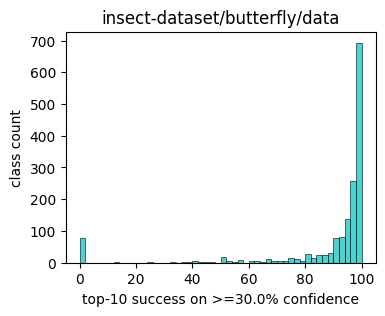

In [12]:
plot_confidence(model_data, f"{dataset_dir}/data", classes, 0.3, k=10)

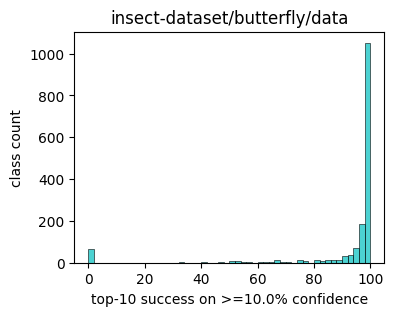

In [10]:
plot_confidence(model_data, f"{dataset_dir}/data", classes, 0.1, k=10)

### Model D (resnet-152 + sorted early & imago data ++more data) ***
mixed stage data sorted now

In [5]:
training_params = [
    { "idx": 1, "robustness": 0.2, "break_at_val_acc_diff": 0.05},
    { "idx": 2, "robustness": 0.5, "break_at_val_acc_diff": 0.02},
    { "idx": 3, "robustness": 1.0, "break_at_val_acc_diff": 0.01},
    { "idx": 4, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 5, "robustness": 2.0, "break_at_val_acc_diff": -0.000001}
]
for param in training_params:
    print(f"Phase {param["idx"]}:")
    if param["idx"] == 1:
        model_data = init_model_for_training(f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                             batch_size=32, arch="resnet152", image_size=224, robustness=param["robustness"],
                                             lr=1e-4, weight_decay=1e-4, silent=True)
    else:
        model_data = prepare_for_retraining(model_data, f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                            batch_size=32, image_size=224, robustness=param["robustness"], silent=True)
    train(model_data, 5, f"{dataset_dir}/checkpoint.butterfly.td.ep{param["idx"]:02}###.pth", 
          break_at_val_acc_diff=param["break_at_val_acc_diff"])

Phase 1:
Epoch    1 /    5  | Train Loss: 2.2902 Acc: 0.5372  | Val Loss: 1.6040 Acc: 0.6294  | Elapsed time: 0:42:04.751332
Epoch    2 /    5  | Train Loss: 0.7161 Acc: 0.8084  | Val Loss: 1.3297 Acc: 0.6412  | Elapsed time: 1:13:53.584539
Phase 2:
Epoch    1 /    5  | Train Loss: 1.4990 Acc: 0.6450  | Val Loss: 1.2204 Acc: 0.6412  | Elapsed time: 0:33:00.253464
Epoch    2 /    5  | Train Loss: 1.2519 Acc: 0.6973  | Val Loss: 1.2474 Acc: 0.6588  | Elapsed time: 1:06:23.765975
Phase 3:
Epoch    1 /    5  | Train Loss: 1.1960 Acc: 0.7106  | Val Loss: 1.1422 Acc: 0.7059  | Elapsed time: 0:33:23.652197
Epoch    2 /    5  | Train Loss: 1.1192 Acc: 0.7288  | Val Loss: 1.1522 Acc: 0.7176  | Elapsed time: 1:06:48.185082
Epoch    3 /    5  | Train Loss: 1.0797 Acc: 0.7393  | Val Loss: 1.1693 Acc: 0.6647  | Elapsed time: 1:39:39.791265
Phase 4:
Epoch    1 /    5  | Train Loss: 0.9208 Acc: 0.7797  | Val Loss: 0.9426 Acc: 0.7706  | Elapsed time: 0:37:52.043884
Epoch    2 /    5  | Train Loss: 0.8

In [4]:
model_data = torch.load(f"{dataset_dir}/checkpoint.butterfly.td.ep050000.pth", weights_only=False)

In [10]:
test_top_k(model_data, f"{dataset_dir}/test", 3, print_preds=False, print_top1_accuracy=True, print_no_match=True)
test_top_k(model_data, f"{dataset_dir}/test", 5, print_preds=False, print_top1_accuracy=False)
test_top_k(model_data, f"{dataset_dir}/test", 10, print_preds=False, print_top1_accuracy=False)

euploea-core-2: 
	 euploea-klugii(0.551)  euploea-godartii(0.239)  euploea-sylvester(0.133)  
unidentified-butterfly-1: 
	 neptis-nata(0.327)  neptis-soma(0.288)  neptis-clinia(0.147)  
Top   1 accuracy: 26/31 -> 83.87%, genus matched: 30/31 -> 96.77%
Top   3 accuracy: 30/31 -> 96.77%, genus matched: 31/31 -> 100.00%
Top   5 accuracy: 31/31 -> 100.00%, genus matched: 31/31 -> 100.00%
Top  10 accuracy: 31/31 -> 100.00%, genus matched: 31/31 -> 100.00%


In [6]:
test_top_k(model_data, f"{dataset_dir}/test2", 3, print_preds=False, print_top1_accuracy=True, print_no_match=False)
test_top_k(model_data, f"{dataset_dir}/test2", 5, print_preds=False, print_top1_accuracy=False)
test_top_k(model_data, f"{dataset_dir}/test2", 10, print_preds=False, print_top1_accuracy=False)

Top   1 accuracy: 117/154 -> 75.97%, genus matched: 139/154 -> 90.26%
Top   3 accuracy: 137/154 -> 88.96%, genus matched: 148/154 -> 96.10%
Top   5 accuracy: 143/154 -> 92.86%, genus matched: 151/154 -> 98.05%
Top  10 accuracy: 147/154 -> 95.45%, genus matched: 152/154 -> 98.70%


In [7]:
pred = validate_prediction_in_dir_top_k(f"{dataset_dir}/val", model_data, 3)
print (f"Top 3 accuracy: {pred['success']}/{pred['total']} -> {100*pred['success']/pred['total']:.2f}%")

Top 3 accuracy: 152/169 -> 89.94%


------------
More data added. refer dataset-analysis2.ipynb
### Updated Dataset Stats

In [8]:
classes = { class_dir: len([ img for img in os.listdir(f"{dataset_dir}/data/{class_dir}") ]) for class_dir in os.listdir(f"{dataset_dir}/data") }
early_classes = { class_name: count for class_name, count in classes.items() if re.match(early_regex, class_name) }
unidentified_classes = { class_name: count for class_name, count in classes.items() if re.match(unidentified_regex, class_name) }
print(f"Total Class count : {len(classes):6} ( Unidentified: {len(unidentified_classes):6} / Early-stage: {len(early_classes):6} / Identified-adult: {len(classes) - len(unidentified_classes) - len(early_classes):6} )")
print(f"Total  Data count : {sum(classes.values()):6} ( Unidentified: {sum(unidentified_classes.values()):6} / Early-stage: {sum(early_classes.values()):6} / Identified-adult: {sum(classes.values()) - sum(unidentified_classes.values()) - sum(early_classes.values()):6} )")

Total Class count :   1735 ( Unidentified:      0 / Early-stage:    452 / Identified-adult:   1283 )
Total  Data count : 127997 ( Unidentified:      0 / Early-stage:  11734 / Identified-adult: 116263 )


In [9]:
img2_class = []
img5_class = []
for class_dir in os.listdir(f"{dataset_dir}/data"):
    if not re.match(early_or_unidentified_regex, class_dir):
        img_cnt = sum([1 for file in os.listdir(f"{dataset_dir}/data/{class_dir}")])
        img2_class += [class_dir] if img_cnt <= 2 else []
        img5_class += [class_dir] if img_cnt <= 5 else []
print(f"{len(img2_class):6} classes with <=2 images")
print(f"{len(img5_class):6} classes with <=5 images")

    55 classes with <=2 images
   151 classes with <=5 images


### Model E (resnet-152 + image transform pipeline fixed)

In [5]:
training_params = [
    { "idx": 1, "robustness": 0.2, "break_at_val_acc_diff": 0.05},
    { "idx": 2, "robustness": 0.5, "break_at_val_acc_diff": 0.02},
    { "idx": 3, "robustness": 1.0, "break_at_val_acc_diff": 0.01},
    { "idx": 4, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 5, "robustness": 2.0, "break_at_val_acc_diff": -0.000001},
    { "idx": 6, "robustness": 2.0, "break_at_val_acc_diff": -0.000001}
]
start_time = time.time()
print("Started at:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
for param in training_params:
    print(f"Phase {param["idx"]}:")
    if param["idx"] == 1:
        model_data = init_model_for_training(f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                             batch_size=32, arch="resnet152", image_size=224, robustness=param["robustness"],
                                             lr=1e-4, weight_decay=1e-4, silent=True)
    else:
        model_data = prepare_for_retraining(model_data, f'{dataset_dir}/data', f'{dataset_dir}/val', 
                                            batch_size=32, image_size=224, robustness=param["robustness"], silent=True)
    train(model_data, 5, f"{dataset_dir}/checkpoint.butterfly.te.ep{param["idx"]:02}###.pth", 
          break_at_val_acc_diff=param["break_at_val_acc_diff"])
    print(f"Current time: {datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | Total elapsed time: {datetime.timedelta(seconds=(time.time() - start_time))}")

Started at: 2025-03-28 01:34:05
Phase 1:
Epoch    0 /    4  | Train Loss: 2.2902 Acc: 0.5367  | Val Loss: 1.5078 Acc: 0.6509  | Elapsed time: 0:46:19.164740
Epoch    1 /    4  | Train Loss: 0.7526 Acc: 0.7955  | Val Loss: 1.4277 Acc: 0.6686  | Elapsed time: 1:21:26.995341
Current time: 2025-03-28 02:55:38 | Total elapsed time: 1:21:33.112174
Phase 2:
Epoch    0 /    4  | Train Loss: 1.5878 Acc: 0.6334  | Val Loss: 1.1783 Acc: 0.6746  | Elapsed time: 0:38:25.171941
Epoch    1 /    4  | Train Loss: 1.3708 Acc: 0.6797  | Val Loss: 1.1337 Acc: 0.7041  | Elapsed time: 1:16:21.101032
Epoch    2 /    4  | Train Loss: 1.2814 Acc: 0.6987  | Val Loss: 1.1449 Acc: 0.7041  | Elapsed time: 1:54:13.032265
Current time: 2025-03-28 04:49:52 | Total elapsed time: 3:15:47.809957
Phase 3:
Epoch    0 /    4  | Train Loss: 1.2890 Acc: 0.6990  | Val Loss: 1.1320 Acc: 0.6627  | Elapsed time: 0:37:45.603121
Epoch    1 /    4  | Train Loss: 1.2394 Acc: 0.7093  | Val Loss: 1.1251 Acc: 0.6864  | Elapsed time: 1:

In [14]:
model_data = torch.load(f"{dataset_dir}/checkpoint.butterfly.te.ep050000.pth", weights_only=False)

In [15]:
test_top_k(model_data, f"{dataset_dir}/test", 3, print_preds=False, print_top1_accuracy=True, print_no_match=True)
test_top_k(model_data, f"{dataset_dir}/test", 5, print_preds=False, print_top1_accuracy=False)
test_top_k(model_data, f"{dataset_dir}/test", 10, print_preds=False, print_top1_accuracy=False)

unidentified-butterfly-1: 
	 neptis-clinia(0.614)  neptis-nata(0.234)  neptis-soma(0.072)  
Top   1 accuracy: 28/31 -> 90.32%, genus matched: 30/31 -> 96.77%
Top   3 accuracy: 31/31 -> 100.00%, genus matched: 31/31 -> 100.00%
Top   5 accuracy: 31/31 -> 100.00%, genus matched: 31/31 -> 100.00%
Top  10 accuracy: 31/31 -> 100.00%, genus matched: 31/31 -> 100.00%


In [16]:
test_top_k(model_data, f"{dataset_dir}/test2", 3, print_preds=False, print_top1_accuracy=True, print_no_match=False)
test_top_k(model_data, f"{dataset_dir}/test2", 5, print_preds=False, print_top1_accuracy=False)
test_top_k(model_data, f"{dataset_dir}/test2", 10, print_preds=False, print_top1_accuracy=False)

Top   1 accuracy: 119/154 -> 77.27%, genus matched: 143/154 -> 92.86%
Top   3 accuracy: 142/154 -> 92.21%, genus matched: 151/154 -> 98.05%
Top   5 accuracy: 145/154 -> 94.16%, genus matched: 152/154 -> 98.70%
Top  10 accuracy: 148/154 -> 96.10%, genus matched: 153/154 -> 99.35%


In [17]:
pred = validate_prediction_in_dir_top_k(f"{dataset_dir}/val", model_data, 3)
print (f"Top 3 accuracy: {pred['success']}/{pred['total']} -> {100*pred['success']/pred['total']:.2f}%")

Top 3 accuracy: 157/169 -> 92.90%


In [18]:
model_data = torch.load(f"{dataset_dir}/checkpoint.butterfly.te.ep060001.pth", weights_only=False)

In [19]:
test_top_k(model_data, f"{dataset_dir}/test", 3, print_preds=False, print_top1_accuracy=True, print_no_match=True)
test_top_k(model_data, f"{dataset_dir}/test", 5, print_preds=False, print_top1_accuracy=False)
test_top_k(model_data, f"{dataset_dir}/test", 10, print_preds=False, print_top1_accuracy=False)

unidentified-butterfly-1: 
	 neptis-clinia(0.627)  neptis-nata(0.227)  neptis-soma(0.076)  
Top   1 accuracy: 27/31 -> 87.10%, genus matched: 30/31 -> 96.77%
Top   3 accuracy: 31/31 -> 100.00%, genus matched: 31/31 -> 100.00%
Top   5 accuracy: 31/31 -> 100.00%, genus matched: 31/31 -> 100.00%
Top  10 accuracy: 31/31 -> 100.00%, genus matched: 31/31 -> 100.00%


In [20]:
test_top_k(model_data, f"{dataset_dir}/test2", 3, print_preds=False, print_top1_accuracy=True, print_no_match=False)
test_top_k(model_data, f"{dataset_dir}/test2", 5, print_preds=False, print_top1_accuracy=False)
test_top_k(model_data, f"{dataset_dir}/test2", 10, print_preds=False, print_top1_accuracy=False)

Top   1 accuracy: 119/154 -> 77.27%, genus matched: 143/154 -> 92.86%
Top   3 accuracy: 141/154 -> 91.56%, genus matched: 151/154 -> 98.05%
Top   5 accuracy: 145/154 -> 94.16%, genus matched: 152/154 -> 98.70%
Top  10 accuracy: 148/154 -> 96.10%, genus matched: 152/154 -> 98.70%


In [21]:
pred = validate_prediction_in_dir_top_k(f"{dataset_dir}/val", model_data, 3)
print (f"Top 3 accuracy: {pred['success']}/{pred['total']} -> {100*pred['success']/pred['total']:.2f}%")

Top 3 accuracy: 156/169 -> 92.31%
